In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

In [126]:
# Download and get Daily Returns
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [127]:
aapl.head()

,Adj. Close
Date,
2012-01-03,52.848787
2012-01-04,53.132802
2012-01-05,53.722681
2012-01-06,54.284287
2012-01-09,54.198183


In [128]:
aapl.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [129]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis=1)
stocks.columns = ['APPLE', 'CISCO', 'IBM', 'AMZN']

In [130]:
stocks.pct_change(1).mean()

APPLE    0.000750
CISCO    0.000599
IBM      0.000081
AMZN     0.001328
dtype: float64

In [131]:
stocks.pct_change(1).corr()

,APPLE,CISCO,IBM,AMZN
APPLE,1.000000,0.301990,0.297498,0.235487
CISCO,0.301990,1.000000,0.424672,0.284470
IBM,0.297498,0.424672,1.000000,0.258492
AMZN,0.235487,0.284470,0.258492,1.000000


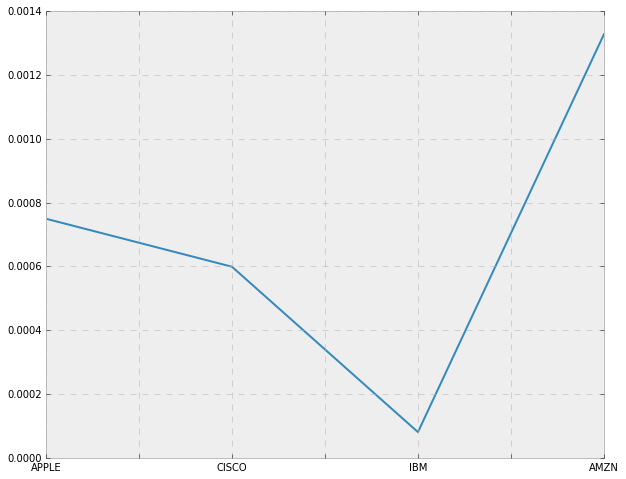

In [132]:
stocks.pct_change(1).mean().plot(figsize=(10,8))

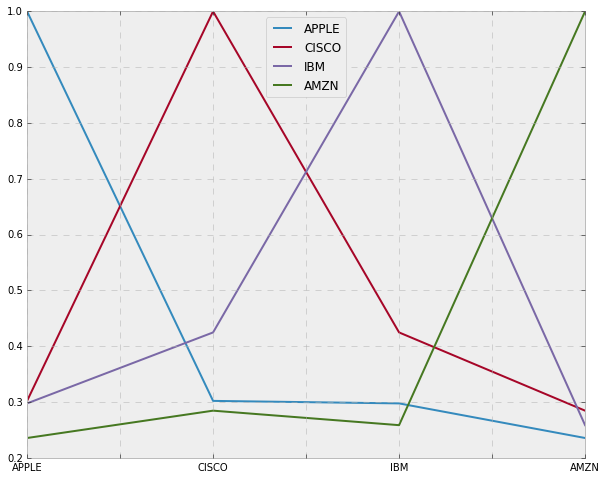

In [133]:
stocks.pct_change(1).corr().plot(figsize=(10,8))

In [134]:
stocks.head()

,APPLE,CISCO,IBM,AMZN
Date,,,,
2012-01-03,52.848787,15.617341,157.578371,179.03
2012-01-04,53.132802,15.919125,156.935540,177.51
2012-01-05,53.722681,15.860445,156.191208,177.61
2012-01-06,54.284287,15.801764,154.398046,182.61
2012-01-09,54.198183,15.902359,153.594506,178.56


In [135]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,APPLE,CISCO,IBM,AMZN
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


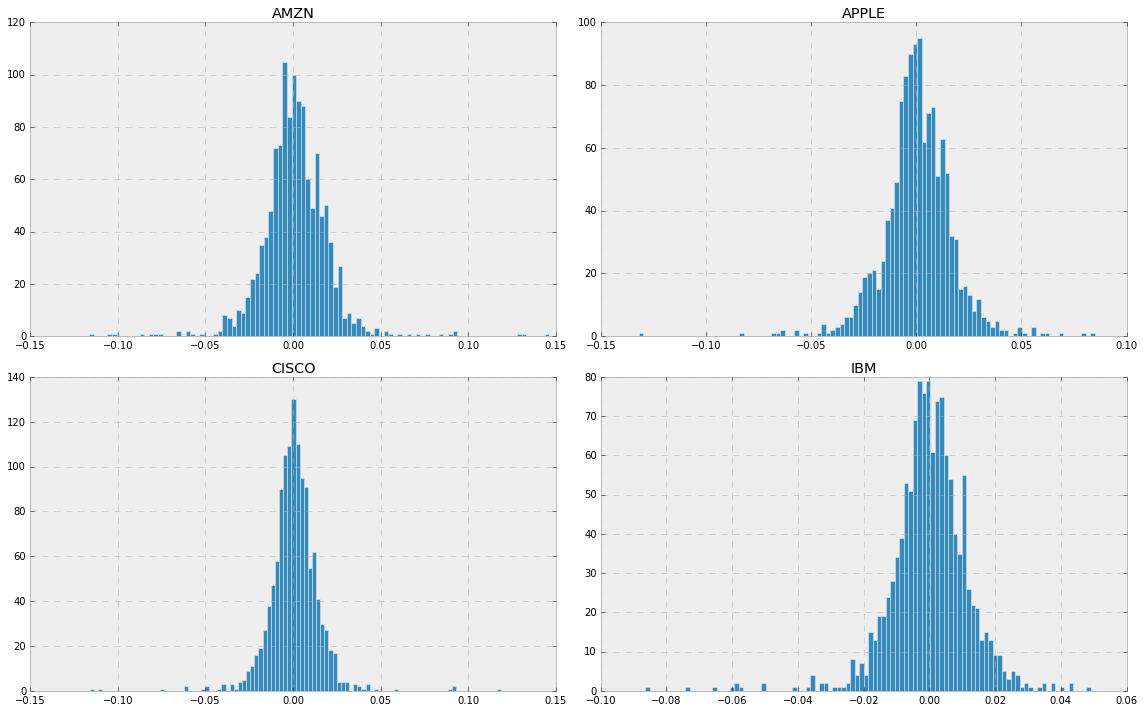

In [136]:
log_ret.hist(bins=100, figsize=(16,10))
plt.tight_layout()

In [137]:
log_ret.mean()

APPLE    0.000614
CISCO    0.000497
IBM      0.000011
AMZN     0.001139
dtype: float64

In [138]:
log_ret.cov() * 252

,APPLE,CISCO,IBM,AMZN
APPLE,0.068326,0.017854,0.014464,0.018986
CISCO,0.017854,0.051381,0.018029,0.019956
IBM,0.014464,0.018029,0.035203,0.014939
AMZN,0.018986,0.019956,0.014939,0.094470


In [140]:
np.random.seed(101)

print(stocks.columns)
weights = np.array(np.random.random(4))

print('Random Weights: ')

print('Rebalance')
weights = weights/np.sum(weights)
print(weights)

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum((log_ret.mean() * weights) * 252)

Index(['APPLE', 'CISCO', 'IBM', 'AMZN'], dtype='object')
Random Weights: 
Rebalance
[ 0.40122278  0.44338777  0.02212343  0.13326603]
Expected Portfolio Return
